# Survey of Consumer Finances Analysis

* Federal Reserve Page: https://www.federalreserve.gov/econres/scfindex.htm 
* Reference Article: https://towardsdatascience.com/linear-regressions-for-the-survey-of-consumer-finances-ed2c10b2670c
* Federal Reserve Data Dictionary: https://www.federalreserve.gov/econres/files/codebk2019.txt

Coding for X6810:

```
 1.    *WHITE (INCLUDE MIDDLE EASTERN/ARAB WITH WHITE);
        Caucasian
 2.    *BLACK/AFRICAN-AMERICAN
 3.    *HISPANIC/LATINO
 4.    *ASIAN
 5.    *AMERICAN INDIAN/ALASKA NATIVE
 6.    *NATIVE HAWAIIAN/PACIFIC ISLANDER
-7.     *OTHER
 0.     Inap. (/no further responses)
 ```

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt 
import requests
import zipfile
import pandas as pd
import numpy as np

In [4]:
race_dict = {
    1:'White',
    2:'Black',
    3:'Hispanic/Latino',
    4:'Asian',
    5:'American Indian/Alaska Native',
    6:'Native Hawaiian/Pacific Islander',
    -7:'Other',
    0:'Inap.'
}

# copying and pasting this code over from reference article

# Global Variables
rename_dict = {'yy1': 'household_id',
               'y1': 'imputed_hh_id',
               'x42001': 'weighting',
               'x5729': 'total_income',
               'x3915': 'stock_mkt_value',
               'x6809': 'race'
              }

def SCF_load_data(targetdir, year, series=None):
    """Loads SCF data for a given year into pandas data frame. Limited to 1989 and on. 
    
            Parameters:
                targetdir (str): String indicating where you want files saved.
                year (str or int): Indicating the year of SCF wanted.
                series (list of strings): Indicating subset of data requested.
            Returns:
                SCF_data (pd.df): Data frame of imported SCF data with labels adjusted 
                according to labels_dict in dataloading.py
    """
    # Set target zip file and relevant url
    targetzip = targetdir + f'SCF{str(year)}_data_public.zip'
    panel_string = 'p' if ((int(year)%3) != 0) else ''
    year = str(year)[-2:] if int(year) < 2002 else str(year)
    url = f'https://www.federalreserve.gov/econres/files/scf{str(year)}{panel_string}s.zip'
        
    # Return list of locations of extracted files   
    SCF_file_locs = URL_DL_ZIP(targetzip, targetdir, url) 
        
    # Read into pandas df    
    SCF_data = pd.read_stata(
        SCF_file_locs[0],
        #insert a list of variables or 'None' to get all
        columns=series)
    
    # Rename some variables of interest
    SCF_data.rename(columns=rename_dict, inplace=True)
    return SCF_data

def SCF_load_summary_data(targetdir, year, series=None):
    """Loads SCF data for a given year into pandas data frame. Limited to 1989 and on. 
    
            Parameters:
                targetdir (str): String indicating where you want files saved.
                year (str or int): Indicating the year of SCF wanted.
                series (list of strings): Indicating subset of data requested.
            Returns:
                SCF_data (pd.df): Data frame of imported SCF data with labels adjusted 
                according to labels_dict in dataloading.py
    """
    # Set target zip file and relevant url
    targetzip = targetdir + f'SCF{str(year)}_data_public.zip'
    panel_string = 'p' if ((int(year)%3) != 0) else ''
    year = str(year)[-2:] if int(year) < 2002 else str(year)
    url = f'https://www.federalreserve.gov/econres/files/scfp{str(year)}{panel_string}s.zip'
        
    # Return list of locations of extracted files   
    SCF_file_locs = URL_DL_ZIP(targetzip, targetdir, url) 
        
    # Read into pandas df    
    SCF_data = pd.read_stata(
        SCF_file_locs[0],
        #insert a list of variables or 'None' to get all
        columns=series)
    
    # Rename some variables of interest
    SCF_data.rename(columns=rename_dict, inplace=True)
    return SCF_data

def URL_DL_ZIP(targetzip, targetdir, url):
    """Downloads and unzips zip file from url and return locations of extracted filed.
    
            Parameters:
                targetzip (str): String indicating where zip file is to be saved.
                targetdir (str): String indicating where files are to be extracted.
                url (str): URL where the zip exists.
            Returns:
                file_locs (list of str): Returns locations for all the extracted files.
    """
        
    # Save Zip from archived site
    r = requests.get(url)
    with open(targetzip,'wb') as f: 
        f.write(r.content)
    
    # Unzipping file
    with zipfile.ZipFile(targetzip, 'r') as zip_ref:
        zip_ref.extractall(targetdir)
        # Get list of files names in zip
        files = zip_ref.namelist()
        
    # Return list of locations of extracted files   
    file_locs = [] 
    for file in files:
        file_locs.append(targetdir + file)
        
    return file_locs

In [54]:
scf_filepath = '/Users/sinasinai/Desktop/'
df = SCF_load_data(scf_filepath, 2019)

In [58]:
df.groupby('race').median()[['total_income','stock_mkt_value']]

,total_income,stock_mkt_value
race,,
-7,103000,0
1,94000,0
2,38000,0
3,45000,0


# Using SCF Summary Data & NET WORTH Summary Variable

Taking Gini coefficient calculator script created here https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy

In [20]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    array += abs(np.amin(array))
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))


In [21]:
scf_filepath = '/Users/sinasinai/Desktop/'
df = SCF_load_summary_data(scf_filepath, 2019)

In [22]:
cols = ['race','networth','wgt']
sub = df.groupby('household_id').mean()[cols]
sub['race'] = sub['race'].map(race_dict)

In [23]:
#Sampling using weights provided to reflect "true" approximate population occurrence

pop = sub.sample(n=5000000,replace=True,weights='wgt')

print('Median household net worth by race')
print('\n')
print(pop.groupby('race').median()['networth'])

print('\n')
print('Mean household net worth by race')
print('\n')
print(pop.groupby('race').mean()['networth'])

Median household net worth by race


race
American Indian/Alaska Native    194280.0
Black                             21138.0
Hispanic/Latino                   36720.0
White                            182950.0
Name: networth, dtype: float64


Mean household net worth by race


race
American Indian/Alaska Native    1.034024e+06
Black                            1.354641e+05
Hispanic/Latino                  1.966060e+05
White                            9.510188e+05
Name: networth, dtype: float64


In [24]:
# Something strange going on with coding for American Indian/Alaska Native bucket, will leave that be for now

print(f"White household: Gini coefficient: {gini(pop.loc[pop.race=='White']['networth'].to_numpy())}")
print(f"Black household: Gini coefficient: {gini(pop.loc[pop.race=='Black']['networth'].to_numpy())}")
print(f"Hispanic/Latino household: Gini coefficient: {gini(pop.loc[pop.race=='Hispanic/Latino']['networth'].to_numpy())}")
print(f"Overall Gini coefficient: {gini(pop['networth'].to_numpy())}")

White household: Gini coefficient: 0.521931950072655
Black household: Gini coefficient: 0.2820728734424054
Hispanic/Latino household: Gini coefficient: 0.15495405521487585
Overall Gini coefficient: 0.38809686155709805


<b> There's more inequality, as measured by the Gini coefficient, within white American households than the general population. </b> Taking another measure of inequality -- difference of 99th/95th percentile to the bottom 1st/5th indicates a huge discrepancy in White households, also indicated by standard deviations below. There's some strange stuff going on with the American Indian/Alaska Native bucket but I suspect that's due to the way they've mapped other groups to this bucket in the public dataset -- will have to dig into later

In [43]:
pop.groupby('race').quantile(q=0.95)['networth'] - pop.groupby('race').quantile(q=0.05)['networth']

race
American Indian/Alaska Native    3968360.0
Black                             602274.0
Hispanic/Latino                   687550.0
White                            3371820.0
Name: networth, dtype: float64

In [44]:
pop.groupby('race').quantile(q=0.99)['networth'] - pop.groupby('race').quantile(q=0.01)['networth']

race
American Indian/Alaska Native    12273520.0
Black                             1540602.0
Hispanic/Latino                   2327444.0
White                            13377780.0
Name: networth, dtype: float64

In [46]:
pop.groupby('race').std()['networth']

race
American Indian/Alaska Native    5.598205e+06
Black                            5.680447e+05
Hispanic/Latino                  1.351335e+06
White                            6.465003e+06
Name: networth, dtype: float64

In [35]:
### Excluding folks with negative net worth in order to use log scaling 
logpop =  pop.copy()
logpop['networth'] += abs(min(pop['networth'])) + 0.0000000001
logpop['log_networth'] = logpop.networth.apply(lambda x: np.log10(x))

We can also clearly see that Blacks and Hispanics have a much higher percentage of the surveyed population with a negative net worth

In [36]:
pop.loc[pop.networth < 0].groupby('race').count()['networth']/pop.groupby('race').count()['networth']

race
American Indian/Alaska Native    0.079900
Black                            0.187840
Hispanic/Latino                  0.116723
White                            0.083130
Name: networth, dtype: float64

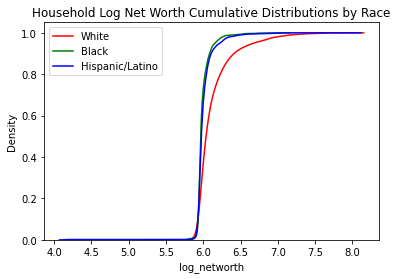

In [52]:
fig = sns.kdeplot(logpop.loc[logpop.race=='White']['log_networth'].sample(10000),label='White',color='Red',alpha=0.3,cumulative=True)
sns.kdeplot(logpop.loc[logpop.race=='Black']['log_networth'].sample(10000),label='Black',color='Green',alpha=0.3,cumulative=True)
sns.kdeplot(logpop.loc[logpop.race=='Hispanic/Latino']['log_networth'].sample(10000),label='Hispanic/Latino',color='Blue',alpha=0.3,cumulative=True)

fig.set_title('Household Log Net Worth Cumulative Distributions by Race')

plt.legend()
plt.show()

In [53]:
pop['networth_pct'] = pop.networth.rank(pct=True)

In [54]:
pop['is_white'] = pop.race.apply(lambda x: x =='White')
pop['is_black'] = pop.race.apply(lambda x: x =='Black')
pop['is_hispanic'] = pop.race.apply(lambda x: x =='Hispanic/Latino')

In [55]:
pop['wealth_pct_bucket'] = pd.cut(pop['networth_pct'],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).astype(str)

In [56]:
pop.groupby('wealth_pct_bucket').mean()[['is_white','is_black','is_hispanic']]

,is_white,is_black,is_hispanic
wealth_pct_bucket,,,
"(0.0, 0.1]",0.551967,0.279238,0.120744
"(0.1, 0.2]",0.435700,0.309170,0.198371
"(0.2, 0.3]",0.541956,0.199600,0.184026
"(0.3, 0.4]",0.586803,0.225822,0.149569
"(0.4, 0.5]",0.695458,0.155540,0.109407
"(0.5, 0.6]",0.721110,0.133289,0.104558
"(0.6, 0.7]",0.765823,0.088356,0.102040
"(0.7, 0.8]",0.789343,0.082481,0.053899
"(0.8, 0.9]",0.813677,0.056107,0.048022
